# Progetto per l'esame di Programmazione di applicazioni di Data Intensive 

<div style="text-align: right">di:  Luca Pesaresi </div>

Il progetto consiste nell'analizzare i dati recuperati dal sito IMDB Internet Movies DataBase) contenente un archivio di informazioni relativi ai titoli di film, serie tv, cortometraggi, ect.
Per effettuare l'analisi mi sono servito di due dataset 
- `imdb_movies.csv` recuperato dal sito https://www.imdb.com/interfaces/
- `user_ratings_imdb.csv` recuperato dal sito https://ieee-dataport.org/open-access/imdb-users-ratings-dataset
 
L'obiettivo è quello di svolere un'unalisi di recommendation, in cui dato un utente venga restituita una lista dei titoli suggeriti con valutazioni più alte

## Librerie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
lib = !pip list -v | grep [Ss]urprise
if not lib:
  !pip install surprise

## Caricamento dei dati

Carichiamo i due dataset

In [3]:
movies = pd.read_csv('imdb_movies.csv')

In [4]:
movies.head(3)

,tconst,type,title,isAdult,year,minutes,genres
0,tt0000001,short,Carmencita,0,1894,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,0,1892,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,0,1892,4.0,"Animation,Comedy,Romance"


In [5]:
user_ratings = pd.read_csv('user-ratings.csv')

In [6]:
user_ratings.head()

,user_id,tconst,rating
0,ur0000001,tt1144884,4
1,ur0000002,tt0119237,2
2,ur0000002,tt0120741,5
3,ur0000002,tt0120746,7
4,ur0000002,tt0129387,7


## Significato delle variabili

#### imdb_movies
- `tconst`: indicizza i titoli del dataset.
- `type`: indica la tipologia di video: film, cortometraggio, serie tv, ect.
- `title`: indica il titolo del video.
- `isAdult`: indica se la visione è ristretta ad un pubblico adulto (1) altrimenti (0). 
- `year`: indica l'anno di rilascio del video, o nel caso di una serie tv l'anno in cui è iniziata.
- `minutes`: riporta il minutaggio del video.
- `genres`: indica il genere rispettivo del video.

#### user_ratings
- `user_id`: indicizza le valutazioni dei ripettivi utenti del dataset.
- `tconst`: indicizza il relativo titolo valutato.
- `rating`: valutazione del video.

## Preparazione dei dati

Vengono sostuiti tutti i valori vuoti con una stringa vuota

In [7]:
movies.dropna(inplace=True)
movies.reset_index(drop=True, inplace=True)

Si convertono le colonne numeriche nel formato intero.

In [8]:
movies["year"] = movies["year"].astype(int)
movies["minutes"] = movies["minutes"].astype(int)

Si rimuovono tutte i dati relativi ai titoli che devono ancora uscire negli anni a venire.

In [9]:
import datetime
year = datetime.datetime.now().year
movies = movies[movies["year"] < year]

In [10]:
movies.size

7882602

## Analisi espolorativa dei dati

Si genera una distribuzione dei titoli a partire dal 1950 ad oggi

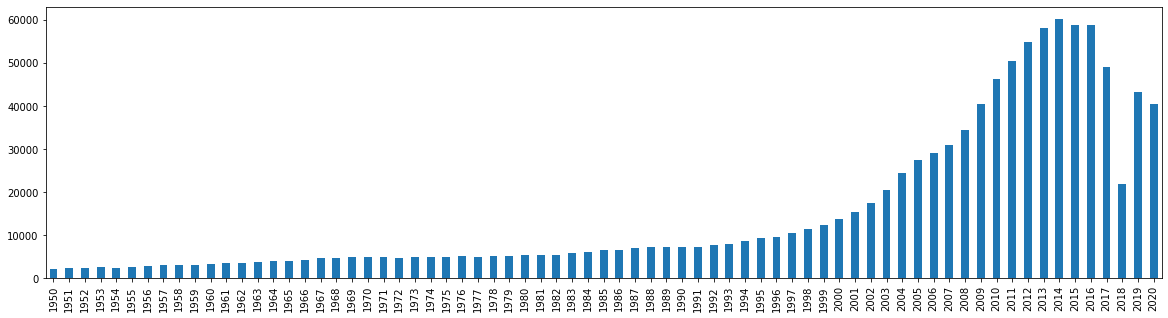

In [11]:
movies.loc[movies["year"] > 1949]["year"].value_counts().sort_index().plot.bar(figsize=(20,5));

Solamente una piccola percentuale dei titoli è riservata ad un pubblico adulto

In [12]:
100*round(movies["isAdult"].value_counts(normalize=True),2)

0    94.0
1     6.0
Name: isAdult, dtype: float64

Dal grafico si notano i generi più di tendenza 

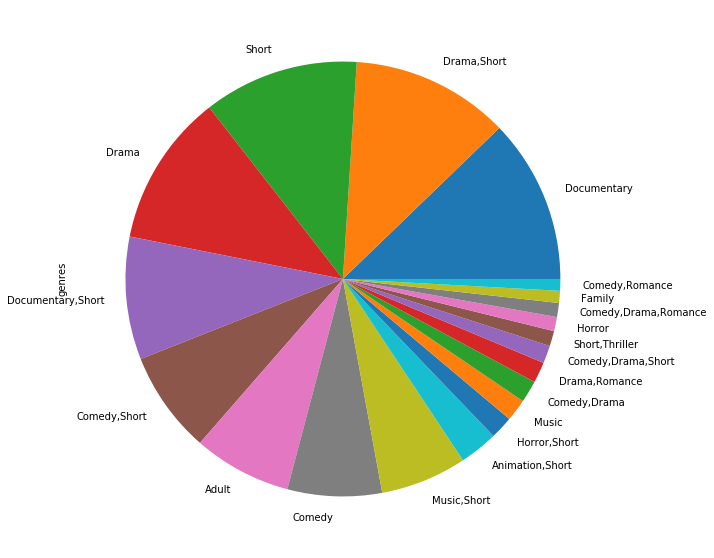

In [13]:
movies["genres"].value_counts(ascending=False)[:20].plot.pie(figsize=(10,10));

In [14]:
user_ratings.describe()

,rating
count,3.974531e+06
mean,6.540254e+00
std,2.516618e+00
min,1.000000e+00
25%,5.000000e+00
50%,7.000000e+00
75%,9.000000e+00
max,1.000000e+01


Confronto tra le varie tipologie di video.

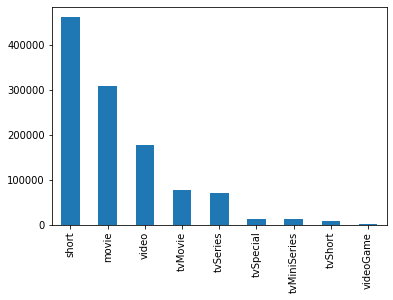

In [15]:
movies["type"].value_counts().plot.bar();

Il dataframe user_ratings contiene le valutazioni per un campione di 1_299_732 utenti per 210_101 titoli con una valutazione ciascuno con un range di 10 voti 

In [16]:
user_ratings.nunique()

user_id    1299732
tconst      210101
rating          10
dtype: int64

La distribuzione dei voti secondo il range di valutazioni 

In [17]:
pd.DataFrame(user_ratings["rating"].value_counts().sort_index()).T

,1,2,3,4,5,6,7,8,9,10
rating,164855,222689,239467,252065,316472,473275,605538,697063,610802,392305


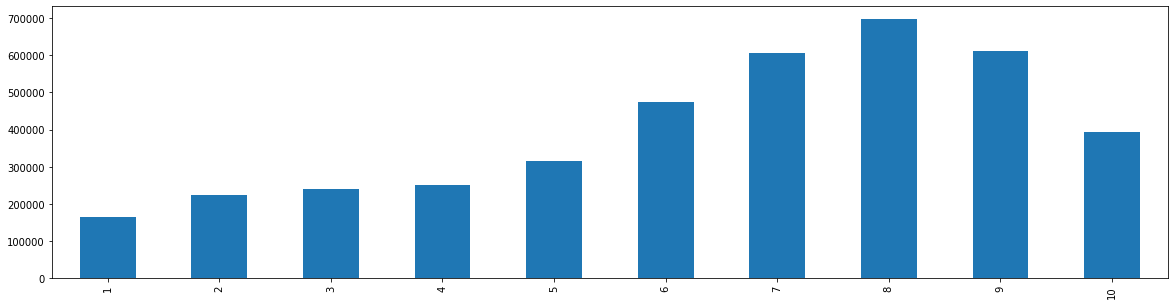

In [18]:
user_ratings["rating"].value_counts().sort_index().plot.bar(figsize=(20, 5));

Si definisce una funzione per limitare le occorrenze al fine di semplificare la visualizzazione dei dati

In [19]:
def lim_df(df, lim):
    df.groupby("user_id").head(lim)
    user_id_max = df["user_id"].unique()[:lim][lim-1]
    last_element = (np.where(df["user_id"] == user_id_max))[0]
    last_element = last_element[len(last_element)-1]
    return df[:last_element]

In [20]:
lim_user = lim_df(user_ratings, 50)

Si vuole ottenere una distribuzione sul numero di valutazioni medie per utente e il numero di valutazioni medie per film

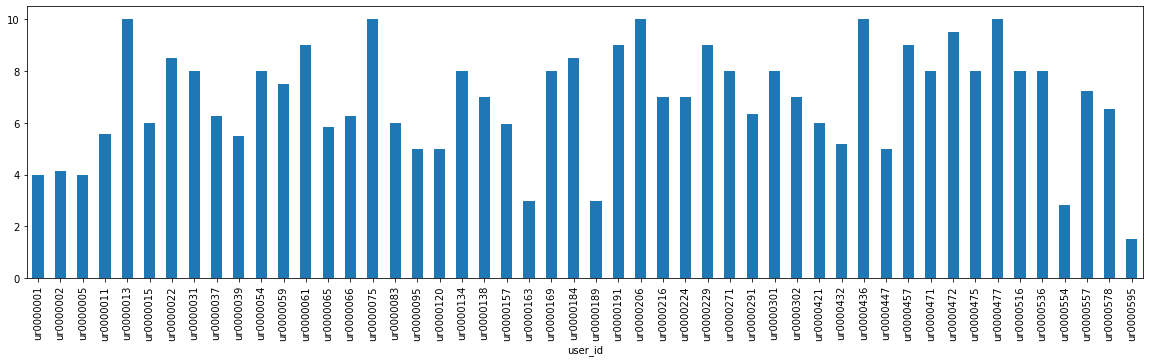

In [21]:
lim_user.groupby("user_id")["rating"].mean().plot.bar(figsize=(20,5));

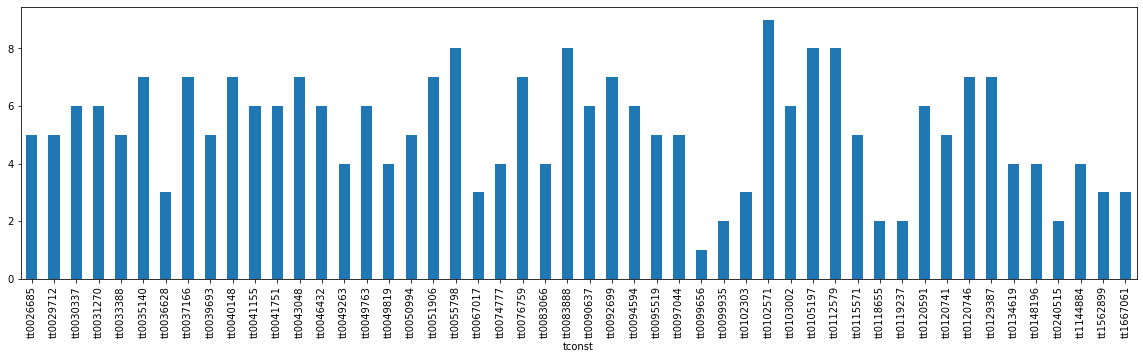

In [22]:
lim_movie = user_ratings.head(50)
lim_movie.groupby("tconst")["rating"].mean().plot.bar(figsize=(20,5));

Dato che le valutazioni degli utenti non sono note all'interno del dataframe `movies`, si ricava un dataframe contenente le medie delle valutazioni per ogni titolo del dataframe `user_ratings`.

In [23]:
ur = user_ratings
means = ur.groupby("tconst")["rating"].mean()
index = pd.Series(means.index.values, name='tconst')
values = pd.Series([round(i,1) for i in means.values], name="rating")
movies_avg = pd.concat([index, values], axis=1)
movies_avg.head()

,tconst,rating
0,tt0000001,6.0
1,tt0000003,7.1
2,tt0000005,7.0
3,tt0000007,6.0
4,tt0000008,7.0


Si unisce il dataframe appena creato con il dataframe movies per aggiungere una valutazione generale per ogni titolo

In [24]:
movies_rated = movies.merge(movies_avg, left_on = 'tconst', right_on = 'tconst')
movies_rated.head()

,tconst,type,title,isAdult,year,minutes,genres,rating
0,tt0000001,short,Carmencita,0,1894,1,"Documentary,Short",6.0
1,tt0000003,short,Pauvre Pierrot,0,1892,4,"Animation,Comedy,Romance",7.1
2,tt0000005,short,Blacksmith Scene,0,1893,1,"Comedy,Short",7.0
3,tt0000007,short,Corbett and Courtney Before the Kinetograph,0,1894,1,"Short,Sport",6.0
4,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,0,1894,1,"Documentary,Short",7.0


Si associano i vari titoli alle relative valutazioni di ogni singolo utente

In [25]:
ur = user_ratings.merge(movies_rated[["tconst","title"]], left_on = 'tconst', right_on = 'tconst')
ur.rename(columns = {'rating':'user_rating'}, inplace = True)
ur = ur[["user_id","title","user_rating"]].sort_values("user_id")
ur.reset_index(drop=True, inplace=True)
ur.head()

,user_id,title,user_rating
0,ur0000001,The Final Destination,4
1,ur0000002,The Mask of Zorro,7
2,ur0000002,There's Something About Mary,7
3,ur0000002,Disturbing Behavior,4
4,ur0000002,Freddy Got Fingered,2


In [26]:
ur.size

11923593

Il dataframe è troppo voluminoso quindi si rimuovono tutti i duplicati e si limita la dimensione a 250 utenti

In [27]:
lim_ur = ur.drop_duplicates(subset=['user_id','title'], keep='first')
lim_ur = lim_df(lim_ur, 250)

In [28]:
lim_ur.size

7284

Si creano due insiemi per l'addestramento e la validazione dei dati

In [29]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(lim_ur, test_size=1/3, random_state=42)

Viene impostato come indice del frame la coppia di colonne `user` e `title`

In [30]:
data_train.set_index(["user_id","title"], inplace=True)

In [31]:
data_train.head()

,,user_rating
user_id,title,
ur0000950,Terminal Velocity,8
ur0002578,Inside Man,9
ur0001220,The Ghost and Mrs. Muir,7
ur0000011,Maid in Manhattan,7
ur0002746,Out of Time,6


Si procede con l'estrazione di una matrice utenti per titoli dove: 
  - ogni riga corrisponde ad un utente $u$
  - ogni colonna corrisponde ad un titolo $i$
  - ogni cella contiene il voto dato dall'utente $u$ a al titolo $t$

Si esegue l'operazione di pivoting `unstack` sull'unica colonna rimasta `user_rating` per portare i titoli dall'indice delle righe a quello delle colonne

In [32]:
train_ratings = data_train["user_rating"].unstack("title") 

In [33]:
train_ratings.iloc[:5, :5]

title,'Neath the Arizona Skies,'Tis Autumn: The Search for Jackie Paris,10 pesos,100 Million BC,102 Dalmatians
user_id,,,,,
ur0000001,NaN,NaN,NaN,NaN,NaN
ur0000002,NaN,NaN,NaN,NaN,NaN
ur0000005,NaN,NaN,NaN,NaN,NaN
ur0000011,NaN,NaN,NaN,NaN,NaN
ur0000013,NaN,NaN,NaN,NaN,NaN


## Creazione dei modelli

###  Raccomendation User-based Collaborative Filtering con similarità coseno

- La <b>recommendation user-based</b>, pemette la previsione di un voto $\hat{r}_{u,t}$ per un titolo $t$ da un utente $u$  in base ai voti dati da altri utenti a $t$, pesati proporzionalmente alla loro somiglianza con l'utente $u$.
- Per calcolare la somiglianza si usa la <b>similarità coseno</b> $\text{sim}(u,v)$ che trova l'angolo formato tra tra due vettori che in questo caso sono le valutazioni tra i due utenti $u$ e $v$
- Nell'approccio <b>collaborative filtering</b> si usa la similarità coseno confrontando i voti dati da entrambi gli utenti

In [34]:
R = train_ratings.fillna(0).values
R[:5,:5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [35]:
P = train_ratings.notna().values
P[:5,:5]

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

Si procede calcolando numeratore e denominatore

In [36]:
cos_num = R @ R.T

In [37]:
P_and = P[:, None, :] & P[None, :, :]
R_com = P_and * R[:, None, :]
R_com_rss = np.sqrt(np.sum(np.square(R_com), 2))
cos_den = R_com_rss * R_com_rss.T

In [38]:
cos = cos_num / cos_den
cos[np.isnan(cos)] = 0
cos[:5, :5]

C:\Users\luca2\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

Si definisce una funzione che dati gli indici utente $u$ e titolo $t$ venga restituito il voto predetto

In [39]:
def predict_from_all(u, t):
    other_users = list(np.where(P[:, t])[0])
    predicted_vote = (cos[u, other_users] @ R[other_users, t]) / cos[u, other_users].sum()
    return predicted_vote if not np.isnan(predicted_vote) else R[P].mean()

In [40]:
predict_from_all(4, 1)

C:\Users\luca2\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


6.484548825710754

Si eseguono le operazioni di indicizzazione sui dati di validazione 

In [41]:
data_test.set_index(["user_id","title"], inplace=True)
val_ratings = data_test["user_rating"].unstack("title") 
val_ratings = val_ratings.reindex_like(train_ratings)

Si creano due matrici 
- R_val contenente i voti, uguali a 0 dove sono mancanti 
- P_val matrice booleana che indica per quali coppie utente-oggetto è presente un voto

In [42]:
R_val = val_ratings.fillna(0).values
P_val = val_ratings.notna().values

Si definisce un vettore `val_actual` con tutti i voti definiti nel validation set

In [43]:
val_actual = R_val[P_val]

Si definisce una funzione che effettui le previsioni dei voti di tutte le coppie utente $u$, titolo $t$ (che hanno già un voto val_actual) sui dati di validazione

In [44]:
def get_val_predictions(pred_func):
    return np.array([pred_func(u, t)
                     for u, t in zip(*np.where(P_val))])

In [45]:
val_predictions = get_val_predictions(predict_from_all)

C:\Users\luca2\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
val_predictions

array([ 6.48454883,  6.48454883,  6.48454883,  6.48454883,  6.        ,
        9.48031469,  8.        ,  6.48454883,  6.48454883,  6.48454883,
        6.48454883,  6.48454883,  6.48454883,  6.48454883,  6.48454883,
        8.        ,  5.        ,  6.48454883,  6.48454883,  6.48454883,
        8.        ,  6.        ,  6.48454883,  7.        ,  6.48454883,
        5.        ,  6.48454883,  5.        ,  6.        ,  3.        ,
        9.        ,  9.        ,  6.48454883,  6.48454883,  6.48454883,
        6.48454883,  6.48454883,  6.48454883,  6.48454883,  6.48454883,
        6.        ,  6.48454883,  6.48454883,  6.48454883,  6.48454883,
        6.48454883,  6.48454883,  6.48454883,  9.        ,  6.48454883,
        6.48454883,  6.48454883,  6.48454883,  6.48454883,  6.48454883,
        6.48454883,  6.48454883,  7.        ,  6.48454883,  3.        ,
        6.        ,  5.        ,  6.48454883,  7.        ,  6.48454883,
        5.        ,  6.48454883,  6.48454883,  4.        ,  6.48

In [47]:
val_actual

array([ 5.,  6.,  6.,  6.,  7.,  1.,  7.,  8.,  5.,  5.,  6.,  5.,  9.,
        3., 10.,  9.,  1.,  8.,  9.,  5.,  8.,  9.,  8.,  5.,  6.,  6.,
        6.,  4.,  8.,  4.,  7.,  6.,  9.,  7.,  6.,  6.,  7.,  4.,  6.,
        6.,  8.,  9.,  5.,  1.,  8.,  8.,  4.,  9.,  9., 10.,  6.,  8.,
       10., 10.,  9.,  2.,  6., 10.,  6.,  7.,  7.,  5.,  3.,  6.,  6.,
        6.,  4., 10.,  9.,  6.,  9.,  3.,  6., 10.,  9.,  6.,  7.,  8.,
        7.,  7.,  8., 10.,  9.,  9.,  3.,  8.,  9.,  8.,  7.,  3.,  8.,
        3.,  5.,  5.,  4.,  8.,  4.,  7.,  6.,  9.,  2.,  7.,  6.,  5.,
        3.,  6.,  7.,  5.,  2.,  8.,  9.,  4.,  1.,  9.,  9.,  9.])

Si definiscono le funzioni per il calcolo dell'errore quadratico medio RMSE e la media degli errori in valore assoluto MAE

In [48]:
def RMSE(actual, predicted):
    return np.sqrt(np.mean(np.square(predicted - actual)))

In [49]:
rmse = RMSE(val_actual, val_predictions)

In [50]:
def MAE(actual, predicted):
    return np.mean(abs(predicted - actual))

In [51]:
mae = MAE(val_actual, val_predictions)

Si definisce una funzione che restituisca un dataframe con i rispettivi errori di accuratezza per ogni modello. 

In [52]:
def update_accuracy(df, model, rmse, mae):
    return df.append(pd.DataFrame([[model, rmse, mae]], columns=df.columns), ignore_index=True)

In [53]:
accuracy = pd.DataFrame(columns=["model","RMSE","MAE"])
accuracy = update_accuracy(accuracy, "cf", rmse, mae)
accuracy

,model,RMSE,MAE
0,cf,2.440524,1.917943


Da quest'analisi possiamo notare che sia il MAE che l'RMSE sono poco accurati utilizzando questo tipo di approccio.

### Surprise

Surprise è una libreria che premette di eseguire un'analisi di studio nella creazione e validazione di modelli di recommendation

In [54]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
reader = Reader(sep=",",rating_scale=(1, 10))

Si usa il dataframe limitato di user_ratings

In [55]:
data = Dataset.load_from_df(lim_ur, reader)

I dati vengono siddivisi in due insiemi: addestramento e validazione.

In [56]:
data_train, data_test = train_test_split(data, test_size=1/3, random_state=42)

Si estraggono alcune informazioni dall'insieme di addestramento

In [57]:
print('Media globale:\t\t{:.2f}'.format(data_train.global_mean)) 
print('Numore utenti:\t\t{}'.format(data_train.n_users)) 
print('Numore titoli:\t\t{}'.format(data_train.n_items)) 
print('Numore valutazioni:\t{}'.format(data_train.n_ratings)) 

Media globale:		6.52
Numore utenti:		202
Numore titoli:		1477
Numore valutazioni:	1618


#### Surprise KNNBasic con Similarità Coseno

Si crea un modello Surprise con la classe KNNBasic, usando similarità coseno e pearson, considerando una selezione di k utenti per ogni predizione, al fine di ottenere un modello migliore si usa anche la Cross-Fold-Validation

In [58]:
from surprise import KNNBasic
from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate, KFold

In [59]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [60]:
model = KNNBasic(k=10, sim_options={"name": "cosine"})
cv_results = cross_validate(model, data, cv=kf)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [61]:
results = pd.DataFrame(cv_results)
results

,test_rmse,test_mae,fit_time,test_time
0,2.144758,1.747347,0.004988,0.010973
1,2.112744,1.706264,0.003989,0.010970
2,2.259743,1.900585,0.004990,0.010968
3,2.328499,1.902456,0.005002,0.008957
4,2.189842,1.803907,0.003990,0.009974


Si esegue una predizione con predict tramite i parametri uid:indice degli user e iid:indice dei titoli

In [62]:
model.predict(1,1)

Prediction(uid=1, iid=1, r_ui=None, est=6.4915079773546065, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [63]:
model.fit(data_train)
pred = model.test(data_test)
rmse(pred), mae(pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.2392
MAE:  1.8435


(2.239226510623208, 1.8434525172061227)

In [64]:
rmse2 = cv_results["test_rmse"].mean()
mae2 = cv_results["test_mae"].mean()
accuracy = update_accuracy(accuracy, "cosine", rmse2, mae2)

#### Surprise KNNBasic con Similarità Pearson

Si ripete l'analisi con similarità pearson

In [65]:
from surprise.accuracy import rmse, mae
model = KNNBasic(k=10, sim_options={"name": "pearson"})
cv_results = cross_validate(model, data, cv=kf)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [66]:
pd.DataFrame(cv_results)

,test_rmse,test_mae,fit_time,test_time
0,2.108197,1.722434,0.005984,0.008976
1,2.094392,1.694671,0.004987,0.006984
2,2.222896,1.869724,0.006979,0.007979
3,2.278373,1.860058,0.003989,0.007980
4,2.190523,1.812931,0.006980,0.004986


In [67]:
model.fit(data_train)
pred = model.test(data_test)
rmse(pred), mae(pred)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 2.2220
MAE:  1.8334


(2.222049688022127, 1.8334172656381147)

In [68]:
rmse3 = cv_results["test_rmse"].mean()
mae3 = cv_results["test_mae"].mean()
accuracy = update_accuracy(accuracy, "pearson", rmse3, mae3)

#### Surprise KNNWithMeans con Similarità Coseno

Si ripete l'analisi precedente con similarità coseno con medie.

In [69]:
from surprise import KNNWithMeans
from surprise.accuracy import rmse, mae
model = KNNWithMeans(k=10, sim_options={"name": "cosine"})
cv_results = cross_validate(model, data, cv=kf)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [70]:
model.fit(data_train)
pred = model.test(data_test)
rmse(pred), mae(pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.2527
MAE:  1.8513


(2.2526520775507883, 1.8513406850633651)

In [71]:
pd.DataFrame(cv_results)

,test_rmse,test_mae,fit_time,test_time
0,2.164688,1.757042,0.009962,0.009973
1,2.130822,1.708233,0.007986,0.014951
2,2.271511,1.900351,0.012969,0.011968
3,2.353164,1.908550,0.010970,0.003990
4,2.235186,1.826455,0.012966,0.006982


In [72]:
rmse4 = cv_results["test_rmse"].mean()
mae4 = cv_results["test_mae"].mean()
accuracy = update_accuracy(accuracy, "means", rmse4, mae4)

#### Surprise KNNBasic con Similarità Coseno title-based

Si ripete l'analisi precedente con similarità coseno con approccio title-based.

In [73]:
from surprise import KNNBasic
model = KNNBasic(k=10, sim_options={"name": "cosine", "user_based": False})
cv_results = cross_validate(model, data, cv=kf)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [74]:
model.fit(data_train)
pred = model.test(data_test)
rmse(pred), mae(pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.2198
MAE:  1.8273


(2.219765287375118, 1.8272591015682624)

In [75]:
pd.DataFrame(cv_results)

,test_rmse,test_mae,fit_time,test_time
0,2.186788,1.793012,0.639290,0.020945
1,2.041933,1.662680,0.534571,0.035905
2,2.249103,1.894243,0.568476,0.014962
3,2.280825,1.859789,0.638294,0.032913
4,2.163438,1.785451,0.617349,0.028924


In [76]:
rmse5 = cv_results["test_rmse"].mean()
mae5 = cv_results["test_mae"].mean()
accuracy = update_accuracy(accuracy, "title-based", rmse5, mae5)

#### Surprise con NormalPredictor

In [77]:
from surprise import NormalPredictor
model = NormalPredictor()
cv_results = cross_validate(model, data, cv=kf)

In [78]:
model.fit(data_train)
pred = model.test(data_test)
rmse(pred), mae(pred)

RMSE: 3.0196
MAE:  2.4031


(3.0196321383473395, 2.4031071986570747)

In [79]:
pd.DataFrame(cv_results)

,test_rmse,test_mae,fit_time,test_time
0,3.024765,2.425577,0.007969,0.008976
1,2.993329,2.372460,0.005984,0.010969
2,3.073498,2.513313,0.004986,0.009974
3,3.033298,2.460429,0.003986,0.004986
4,2.928770,2.376674,0.003986,0.007980


In [80]:
rmse6 = cv_results["test_rmse"].mean()
mae6 = cv_results["test_mae"].mean()
accuracy = update_accuracy(accuracy, "normal", rmse6, mae6)

#### Surprise con SVD

SVD è una libreria apposita per eseguire un'analisi di recommendation casuale

In [81]:
from surprise import SVD
model = SVD(n_factors=5, random_state=42)
cv_results = cross_validate(model, data, cv=kf)

In [82]:
model.fit(data_train)
pred = model.test(data_test)
rmse(pred), mae(pred)

RMSE: 2.1727
MAE:  1.7872


(2.1726940756892485, 1.787161862653741)

In [83]:
pd.DataFrame(cv_results)

,test_rmse,test_mae,fit_time,test_time
0,2.090797,1.702945,0.074803,0.011966
1,2.029881,1.637338,0.073802,0.007978
2,2.178510,1.812346,0.053856,0.003988
3,2.221496,1.794470,0.052860,0.008976
4,2.106561,1.739308,0.066820,0.006982


In [84]:
rmse7 = cv_results["test_rmse"].mean()
mae7 = cv_results["test_mae"].mean()
accuracy = update_accuracy(accuracy, "SVD", rmse7, mae7)

## Valutazione dei modelli

Grafico di confronto trai i valori RMSE e MAE riportati dai modelli di recommendation

In [85]:
accuracy.set_index("model", inplace=True)

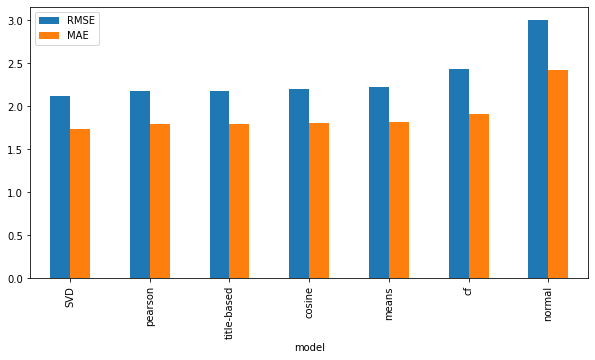

In [86]:
accuracy.sort_values("RMSE").plot.bar(figsize=(10,5));

In [87]:
accuracy.sort_values("RMSE").T

model,SVD,pearson,title-based,cosine,means,cf,normal
RMSE,2.125449,2.178876,2.184417,2.207117,2.231074,2.440524,3.010732
MAE,1.737281,1.791964,1.799035,1.812112,1.820126,1.917943,2.429690


Dei modelli studiati quello che risulta con un'accuratezza migliore in termini di RMSE e MAE è SVD.

## Ricerca del modello migliore

### Grid Search

Grid Search si utilizza per individuare i parametri migliori per il modello in questione.

In [88]:
from surprise.model_selection import GridSearchCV

In [89]:
grid = {
    "n_factors": list(range(5,50,5)),
    'n_epochs':[20,30],  
    'random_state': [42],
    'lr_all':[0.01],
    'reg_all':[0.1]
}

In [90]:
gs = GridSearchCV(SVD, grid, cv=kf, refit=True)
gs.fit(data)

In [91]:
gs.best_params

{'rmse': {'n_factors': 20,
  'n_epochs': 20,
  'random_state': 42,
  'lr_all': 0.01,
  'reg_all': 0.1},
 'mae': {'n_factors': 15,
  'n_epochs': 30,
  'random_state': 42,
  'lr_all': 0.01,
  'reg_all': 0.1}}

In [92]:
pd.DataFrame(gs.cv_results).sort_values("mean_test_rmse")

,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,split4_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_random_state,param_lr_all,param_reg_all
6,2.079381,2.036058,2.184443,2.213255,2.098345,2.122296,0.066315,1,1.686740,1.636938,...,0.070411,0.012998,0.004987,0.001669,"{'n_factors': 20, 'n_epochs': 20, 'random_stat...",20,20,42,0.01,0.1
4,2.075452,2.036778,2.181014,2.221762,2.097551,2.122512,0.068500,2,1.681745,1.635730,...,0.076598,0.018257,0.004784,0.001931,"{'n_factors': 15, 'n_epochs': 20, 'random_stat...",15,20,42,0.01,0.1
16,2.085567,2.035662,2.183650,2.214156,2.098188,2.123445,0.065775,3,1.689052,1.641675,...,0.098788,0.009819,0.004987,0.001785,"{'n_factors': 45, 'n_epochs': 20, 'random_stat...",45,20,42,0.01,0.1
10,2.082375,2.034160,2.184600,2.215683,2.100431,2.123450,0.066987,4,1.690768,1.637146,...,0.080186,0.016805,0.005584,0.002644,"{'n_factors': 30, 'n_epochs': 20, 'random_stat...",30,20,42,0.01,0.1
7,2.078122,2.042525,2.190133,2.211964,2.098619,2.124273,0.065571,5,1.683163,1.641257,...,0.113496,0.017587,0.004588,0.001017,"{'n_factors': 20, 'n_epochs': 30, 'random_stat...",20,30,42,0.01,0.1
17,2.084146,2.037313,2.187406,2.212599,2.100254,2.124343,0.065630,6,1.683664,1.643567,...,0.127858,0.008355,0.005385,0.001352,"{'n_factors': 45, 'n_epochs': 30, 'random_stat...",45,30,42,0.01,0.1
5,2.070351,2.042012,2.185808,2.223534,2.100310,2.124403,0.069120,7,1.674849,1.639416,...,0.088762,0.003835,0.005385,0.001738,"{'n_factors': 15, 'n_epochs': 30, 'random_stat...",15,30,42,0.01,0.1
11,2.081852,2.036212,2.188242,2.215775,2.102617,2.124940,0.067061,8,1.688963,1.638657,...,0.124065,0.024758,0.005586,0.000489,"{'n_factors': 30, 'n_epochs': 30, 'random_stat...",30,30,42,0.01,0.1
2,2.080750,2.043560,2.184666,2.217967,2.099005,2.125190,0.065527,9,1.685760,1.648622,...,0.058044,0.014485,0.005185,0.001464,"{'n_factors': 10, 'n_epochs': 20, 'random_stat...",10,20,42,0.01,0.1
0,2.081126,2.040861,2.182712,2.214909,2.106993,2.125320,0.064409,10,1.687592,1.641944,...,0.061836,0.014287,0.005784,0.001714,"{'n_factors': 5, 'n_epochs': 20, 'random_state...",5,20,42,0.01,0.1


Si calcola RMSE e MAE sul validation set del modello migliore individuato

In [93]:
preds = gs.test(data_test)
rmse(preds), mae(preds)

RMSE: 1.0883
MAE:  0.8502


(1.088255573660189, 0.8502113590747339)

Si definisce una funzione Recommend che prende in input l'indice numerico di un utente e che restituisce una lista dei film con valutazione più simile alle sue

In [94]:
def recommend(uid, n_recomms):
    user_id = user_ratings["user_id"].unique()[uid]
    preds = [gs.predict(user_id, data_train.to_raw_iid(ii))
             for ii in range(data_train.n_items)]
    preds.sort(key=lambda p: p.est, reverse=True)
    return pd.DataFrame([(p.iid, p.est) for p in preds[:n_recomms]], columns=["title","rating"])

In [95]:
recommend(900, 10)

,title,rating
0,The Matrix,7.916165
1,The Sixth Sense,7.840697
2,"South Park: Bigger, Longer & Uncut",7.590330
3,"Crouching Tiger, Hidden Dragon",7.418708
4,Saving Private Ryan,7.372068
5,Breaking the Waves,7.367003
6,Being John Malkovich,7.343556
7,The Lord of the Rings: The Fellowship of the Ring,7.339380
8,Rush Hour,7.310901
9,Buffalo '66,7.284532


 ## Conclusioni

In conclusione ritengo soddifacente l'accuratezza raggiunta dal modello di valutazione, grazie a questi modelli è stato possibile effettuare uno studio e un'analisi sul dataset, con lo scopo di ottenere una previsione approssimativa dei film da consigliare ad un utente in base al suo profilo di valutazioni.